In [1]:
## V3: tidy up for sharing, and improve figures. 
## Additionally, this version incorporates uniform time-sampling for observation means

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import json
import cftime
from itertools import product
from cftime import DatetimeNoLeap
import esmvalcore.preprocessor
import xesmf as xe
from xmip.preprocessing import promote_empty_dims, broadcast_lonlat, replace_x_y_nominal_lat_lon, rename_cmip6
from tqdm import tqdm
import dask
from scipy import stats
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator


f = 0.1 # fraction of data points to include in KDE plots...
## ... Use 1 to include all points, at the expense of slower, spikier KDEs

In [2]:
dirs = {'open_ocean':'open_ocean_monthly_inversions_15',
        'sea_ice':'sea_ice_monthly_inversions'}



In [3]:
DF = pd.DataFrame(columns=['LLS', 'Model', 'Ens_mem'])

dirs = {'open_ocean':'open_ocean_monthly_inversions_15/',
        'sea_ice':'sea_ice_monthly_inversions/'}

for region in ['open_ocean', 'sea_ice']:    
    dir = dirs[region]
    for file in os.listdir(dir):
        if '.csv' in file:
            model = file.split('_')[0]
            ens_mem = file.split('_')[1].split('.cs')[0]
            df = pd.read_csv(dir+file, header=None).dropna()
            df.columns = ['LLS']
            df['Region'] = region
            df['Model'] = model
            df['Ens_mem'] = ens_mem
            DF = pd.concat([DF, df])

## keep only first ens member:
print(len(DF))
DF = DF[DF['Ens_mem'].str.contains('r1i')]
print(len(DF))

## E3SM-1-1 and E3SM-1-1-ECA have a couple of very large LLS values as nan fills, drop these:
DF = DF[DF['LLS'] < 100000]
print(len(DF))


15092872
14511771
14511528


In [4]:
summary_DF = DF.groupby(["Model", "Ens_mem", "Region"])[['LLS']].mean().reset_index()
summary_DF.to_csv('LLS_sumary.csv')

In [5]:
print(DF[DF['Region']=='sea_ice']['LLS'].mean())

6.604089417128459


In [6]:
len(DF.Model.unique())

45

In [7]:
###  now repeat the above, with obs added 
# plot only means for obs comparison, because of different time resolutions


# read in obs:
MOSAiC_file = '../Processed_obs/MOSAiC.csv'
df_M = pd.read_csv(MOSAiC_file)
df_M['Campaign'] = 'MOSAiC'

SHEBA_file = '../Processed_obs/SHEBA.csv'
df_S = pd.read_csv(SHEBA_file)
df_S['Campaign'] = 'SHEBA'


NP_file = '../Processed_obs/NP.csv'
df_N = pd.read_csv(NP_file)
df_N['Campaign'] = 'NP'

DF_obs = pd.concat([df_M, df_S, df_N])
Campaigns = DF_obs['Campaign'].unique()

winter_months = [11, 12, 1, 2, 3]

DF_obs = DF_obs[DF_obs['month'].isin(winter_months)]

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}

In [8]:
## get uniformly time-sampled Obs means, and print these, as well as the simple means:

# get raw means, for comparison later
raw_obs_lls_means = DF_obs.groupby('Campaign')['low_level_stability'].mean().reset_index()
raw_obs_lls_means = raw_obs_lls_means.sort_values(['low_level_stability'])

raw_obs_tas_means = DF_obs.groupby('Campaign')['t0'].mean().reset_index()
raw_obs_tas_means = raw_obs_tas_means.sort_values(['t0'])


df_M = df_M[df_M['month'].isin(winter_months)]
df_S = df_S[df_S['month'].isin(winter_months)]
df_N = df_N[df_N['month'].isin(winter_months)]

## first, group by date to account for any sampling bias towards extreme weather (as is reported for MOSAiC)
df_M['Date'] = pd.DatetimeIndex(df_M.dt_).strftime('%Y-%m-%d')
df_S['Date'] = pd.DatetimeIndex(df_S.dt_).strftime('%Y-%m-%d')
df_N['Date'] = df_N['year'].map(str)+'-'+df_N['month'].map(str)+'-'+df_N['day'].map(str)

df_M_gD = df_M.groupby('Date').mean().reset_index()
df_S_gD = df_S.groupby('Date').mean().reset_index()
df_N_gD = df_N.groupby('Date').mean().reset_index()

## second, group by month, to account for uneven sampling across the extended winter season
df_M_gMgD = df_M_gD.groupby('month').mean().reset_index()
df_S_gMgD = df_S_gD.groupby('month').mean().reset_index()
df_N_gMgD = df_N_gD.groupby('month').mean().reset_index()

month_lengths = [31, 28, 31, 30, 31] #JFMND (1,2,3,11,12)

In [9]:
print(len(df_M), len(df_S), len(df_N))

340 276 6999


In [10]:
DF_obs.columns

Index(['Unnamed: 0', 't0', 'dt0', 'month', 'lon', 'lat', 'inversion_strength',
       'inversion_height', 'low_level_stability', 'rh_sub_850',
       'surf_wind_velocity', 'wind_shear', 'dt_', 'Campaign', 'station',
       'SNT_IND', 'ELEV', 'year', 'day', 'GMT_hour', 'GMT_minute',
       'STD_GMT_TIME', 'local_time', 'RELSE_TIME', 'latitude', 'longitude',
       'min_altitude', 'max_altitude', 'OBSN_TYPE', 'QC_EFFORT', 'DATA_SRCE',
       'NUM_LVLS', 'INST_CODE', 'CLOUD_AMOUNT', 'CLOUD_AMOUNT_QLTY',
       'LOWER_CLOUD', 'CLOUD_HEIGHT', 'CLOUD_HEIGHT_QLTY', 'MID_CLOUD',
       'MID_CLOUD_QLTY', 'HIGH_CLOUD', 'HIGH_CLOUD_QLTY', 'date', 'npoints',
       'npoints_sub3000', 'cloudiness', 'cloud_quality'],
      dtype='object')

In [11]:
#print(len(DF_obs.dropna(subset=['low_level_stability', ]))

In [12]:
LLS_M = np.average(df_M_gMgD['low_level_stability'], weights=month_lengths)
LLS_S = np.average(df_S_gMgD['low_level_stability'], weights=month_lengths)
LLS_N = np.average(df_N_gMgD['low_level_stability'], weights=month_lengths)

tas_M = np.average(df_M_gMgD['t0'], weights=month_lengths)
tas_S = np.average(df_S_gMgD['t0'], weights=month_lengths)
tas_N = np.average(df_N_gMgD['t0'], weights=month_lengths)

LLS_obs_means = dict(zip(['MOSAiC', 'SHEBA', 'NP'], [LLS_M, LLS_S, LLS_N]))
tas_obs_means = dict(zip(['MOSAiC', 'SHEBA', 'NP'], [tas_M, tas_S, tas_N]))

In [13]:
### check the impact of uniform time sampling:
print(raw_obs_lls_means)
print(LLS_obs_means)
for campaign in ['MOSAiC', 'SHEBA', 'NP']:
    r=raw_obs_lls_means[raw_obs_lls_means['Campaign']==campaign]['low_level_stability'].item()
    print(campaign, ': ', str(np.round((100*(LLS_obs_means[campaign] - r)/r), 3)), '%')

  Campaign  low_level_stability
0   MOSAiC             5.195429
2    SHEBA             8.332112
1       NP             9.426910
{'MOSAiC': 4.952700166915141, 'SHEBA': 8.25951147305165, 'NP': 9.52551461684594}
MOSAiC :  -4.672 %
SHEBA :  -0.871 %
NP :  1.046 %


In [14]:
## also get uniformly time sampled mean for each NP station:
df_N_gDS = df_N.groupby(['Date', 'station']).mean().reset_index()
df_N_gMgDS = df_N_gDS.groupby(['month', 'station']).mean().reset_index()
lengths = []
stations=[]
for s in df_N_gMgDS['station'].unique():
    stations.append(s)
    lengths.append(len(df_N_gMgDS[df_N_gMgDS['station']==s]))
ls = dict(zip(stations, lengths))
stations_to_drop_from_means = []
for s in ls.keys():
    if ls[s] < 5:
        stations_to_drop_from_means.append(s)
#print(stations_to_drop_from_means)

df_N_gMgDS = df_N_gMgDS[~df_N_gMgDS['station'].isin(stations_to_drop_from_means)]

NP_station_means_lls = []
for station in df_N_gMgDS['station'].unique():
    x = df_N_gMgDS[df_N_gMgDS['station']==station]['low_level_stability']
    NP_station_means_lls.append(np.average(x, weights=month_lengths))
#NP_station_means_lls

# note that we drop two stations which don't have data for all 5 months from the station mean calculation

In [15]:
print(np.std(NP_station_means_lls))
print(np.min(NP_station_means_lls))

0.935057631683912
7.60283854761361


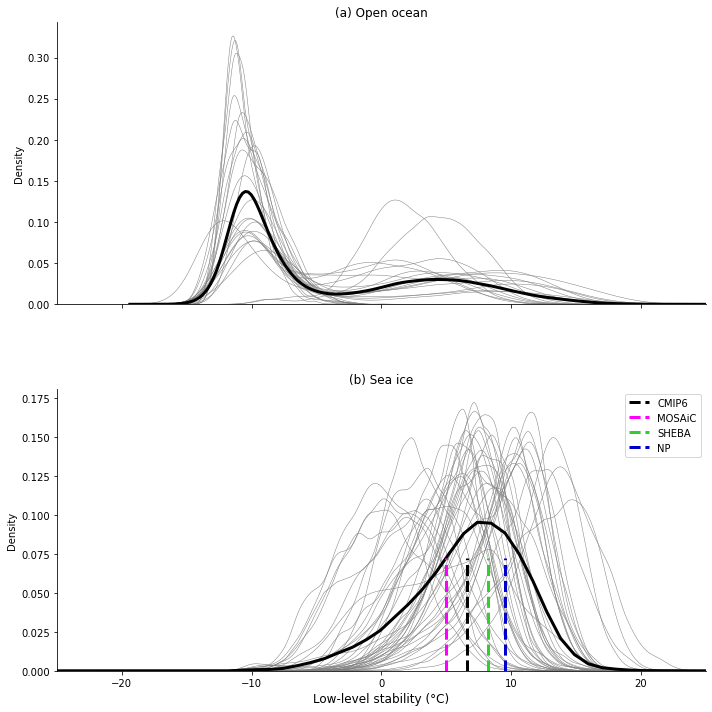

In [16]:
#### KDE plot with obs

colors = {'MOSAiC': 'magenta',
          'SHEBA': 'limegreen',
          'NP': 'mediumblue'}

matplotlib.rcParams.update({'font.size': 16})

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,10), sharex=True)
i=0
titles = {'open_ocean': '(a) Open ocean',
          'sea_ice': '(b) Sea ice'}
for region in ['open_ocean', 'sea_ice']:
    data=DF[DF['Region']==region]
    models = data['Model'].unique()
    for mod in models:
        plt_data = data[data['Model']==mod]['LLS'].sample(frac=f)
        #axs[i].hist(plt_data, bins = 50, histtype='step', density=True)
        sns.kdeplot(ax = axs[i], data=plt_data, color='gray', lw=0.5)
    #            x="LLS", hue="Model", bins=30)
        #label=mod)
        #axs[i].legend()
        axs[i].set_title(titles[region], 
                         fontsize='large')
    sns.kdeplot(ax = axs[i], data=data['LLS'].sample(frac=f), color='black',
                lw=3)
    if region =='sea_ice':
        mean = np.mean(data['LLS'])
        axs[i].axvline(x=mean, color='black', ls='--', ymin=0, ymax=0.4, lw=3, label='CMIP6')
    axs[i].spines[['right', 'top']].set_visible(False)
    i=i+1
axs[1].set_xlabel('Low-level stability (°C)', fontsize='large')


for key in LLS_obs_means.keys():
    axs[1].axvline(x=LLS_obs_means[key], color=colors[key], label=key, ls='--', ymin=0, ymax=0.4, lw=3)


axs[1].set_xlim([-25, 25])
axs[1].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig('Figures/Mean_LLS_PDFs_with_obs.png', dpi=300)

In [17]:
mods_with_positive_lls_open_ocean = []
data=DF[DF['Region']=='open_ocean']
models = data['Model'].unique()
for mod in models:
    if np.mean(data[data['Model']==mod]['LLS']) > 0:
        mods_with_positive_lls_open_ocean.append(mod)
print(mods_with_positive_lls_open_ocean)

['GISS-E2-1-H', 'GISS-E2-2-H', 'NorCPM1']


6.604089417128459


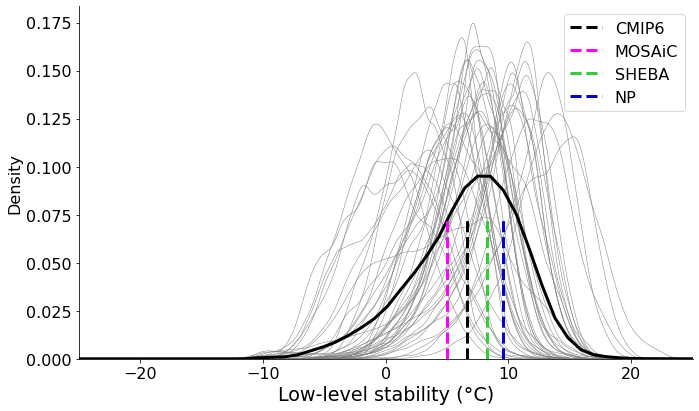

In [18]:
### repeat the above, just with fig b

#### KDE plot with obs
matplotlib.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
i=0
titles = {'open_ocean': '(a) Open ocean',
          'sea_ice': '(b) Sea ice'}

region = 'sea_ice'
data=DF[DF['Region']==region]

models = data['Model'].unique()
for mod in models:
    plt_data = data[data['Model']==mod]['LLS'].sample(frac=f)
    sns.kdeplot(ax = ax, data=plt_data, color='gray', lw=0.5)
    
sns.kdeplot(ax = ax, data=data['LLS'].sample(frac=f), color='black', lw=3)
if region =='sea_ice':
    mean = np.mean(data['LLS'])
    print(mean)
    ax.axvline(x=mean, color='black', ls='--', ymin=0, ymax=0.4, lw=3, label='CMIP6')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Low-level stability (°C)', fontsize='large')


for key in LLS_obs_means.keys():
    ax.axvline(x=LLS_obs_means[key], color=colors[key], label=key, ls='--', ymin=0, ymax=0.4, lw=3)

ax.set_xlim([-25, 25])
ax.legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.savefig('Figures/Mean_LLS_PDFs_with_obs_justSI.png', dpi=300)

In [19]:

NP_LLS_SD = np.std(DF_obs.groupby(['Campaign', 'station'])['low_level_stability'].mean().reset_index()['low_level_stability'])

model_means = DF[DF['Region']=='sea_ice'].groupby('Model')['LLS'].mean().reset_index().sort_values(by='LLS', ascending=True)
model_stds = DF[DF['Region']=='sea_ice'].groupby('Model')['LLS'].std().reset_index().sort_values(by='LLS', ascending=True) 

mm_mean = model_means['LLS'].mean()
mm_sd = model_means['LLS'].std()

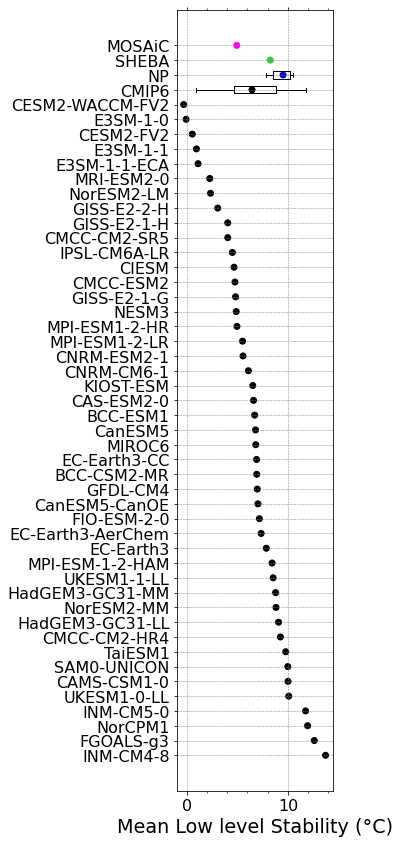

In [20]:
means = np.concatenate((np.array(list(LLS_obs_means.values())), [mm_mean], model_means['LLS'].values))
labels = np.concatenate((np.array(list(LLS_obs_means.keys())), ['CMIP6'], model_means['Model'].values))

scatter_colors_obs = [colors[campaign] for campaign in LLS_obs_means.keys()]
scatter_colors_obs.reverse()
scatter_colors_mm_mean = ['black']
scatter_colors_mods = ['black' for i in model_means['LLS'].values]
scatter_colors =  scatter_colors_mods + scatter_colors_mm_mean + scatter_colors_obs 

fig, ax = plt.subplots(figsize=(5, 12))

ax.boxplot(model_means['LLS'],positions=[len(model_means)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


ax.boxplot(NP_station_means_lls,
           positions=[len(model_means)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)

ax.scatter(np.flip(means), np.flip(labels), c=scatter_colors)
ax.set_xlabel(f'Mean Low level Stability (°C)',fontsize='large')

ax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
plt.tight_layout()
plt.savefig('Figures/model_obs_comparison_mean_state_lls.png', dpi=300)
plt.show()

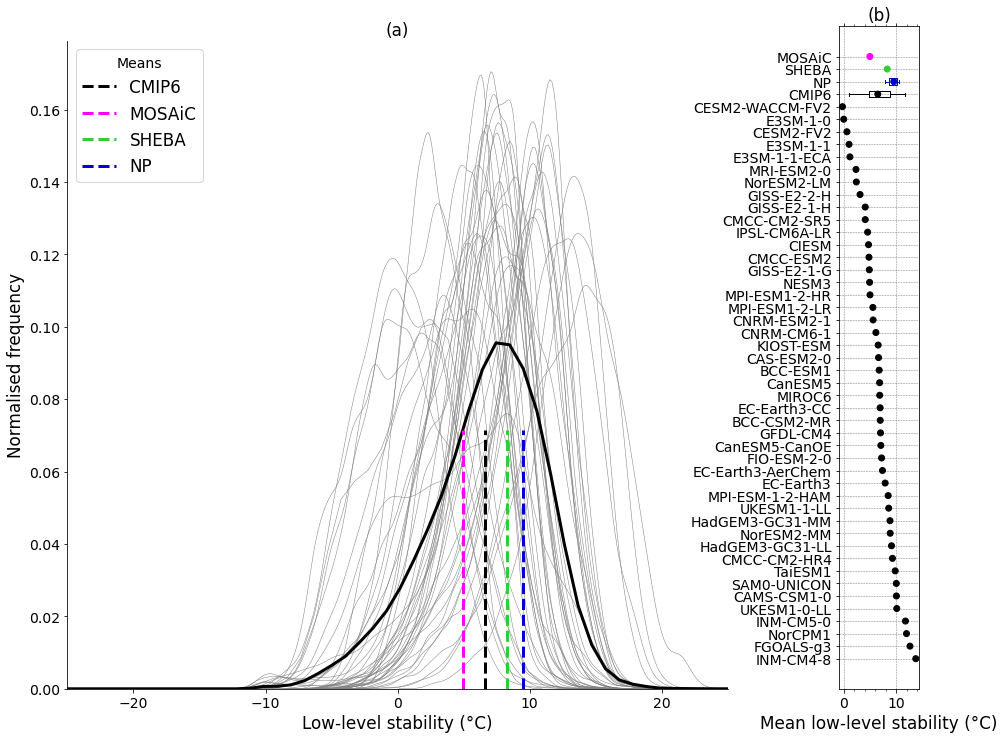

In [21]:
### now combine the column plot and the kde:

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,10))
i=0
titles = {'open_ocean': '(a) Open ocean',
          'sea_ice': '(b) Sea ice'}

region = 'sea_ice'
data=DF[DF['Region']==region]

models = data['Model'].unique()
for mod in models:
    plt_data = data[data['Model']==mod]['LLS'].sample(frac=f)
    sns.kdeplot(ax = ax, data=plt_data, color='gray', lw=0.5)

sns.kdeplot(ax = ax, data=data['LLS'].sample(frac=f), color='black', lw=3)

if region =='sea_ice':
    mean = np.mean(data['LLS'])
    ax.axvline(x=mean, color='black', ls='--', ymin=0, ymax=0.4, lw=3, label='CMIP6')
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Low-level stability (°C)', fontsize='large')

for key in LLS_obs_means.keys():
    ax.axvline(x=LLS_obs_means[key], color=colors[key], label=key, ls='--', ymin=0, ymax=0.4, lw=3)
  
ax.set_xlim([-25, 25])
ax.set_ylabel('Normalised frequency', fontsize='large')
ax.set_title('(a)')
ax.legend(loc='upper left',fontsize='large', title='Means')

plt.tight_layout()

plt.subplots_adjust(bottom=0.1, right=0.73, top=1)
cax = plt.axes((0.84, 0.1, 0.08, 0.92))
cax.boxplot(model_means['LLS'],positions=[len(model_means)],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)


bpNP = cax.boxplot(NP_station_means_lls,
           positions=[len(model_means)+1],widths=0.5,
           showmeans=False,
           whis=[5, 95], showfliers=False,
           medianprops={'linewidth':0},
           meanprops={'marker':'o',
                      'markersize':8,
                      'markerfacecolor':'black',
                      'markeredgecolor':'black'},
          vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bpNP[element], color=colors['NP'])

cax.scatter(np.flip(means), np.flip(labels), c=scatter_colors)
cax.set_xlabel(f'Mean low-level stability (°C)',fontsize='large')

cax.tick_params(axis="x",direction="out", which='both', top=True, labeltop=False, bottom=True, labelbottom=True)
cax.xaxis.set_minor_locator(AutoMinorLocator())
cax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
cax.set_axisbelow(True)
cax.set_yticks(np.arange(len(labels)))
cax.set_yticklabels(np.flip(labels),rotation=0, fontsize='medium') 
cax.set_title('(b)')


plt.savefig('Figures/Combined_LLS_KDE_and_means.jpg', dpi=500)
plt.show()


In [22]:
## cell takes a couple minutes

dirs = {'hfss':'sea_ice_monthly_hfss/',
        'windscaled_hfss':'sea_ice_monthly_hfss_div_sfcWind/',
        'clwvi':'sea_ice_monthly_cloud_clwvi/',
        'clivi_div_clwvi':'sea_ice_monthly_cloud_ice_fractions/'}

vars = list(dirs.keys())

DF = pd.DataFrame(columns=['Model', 'Ens_mem'])

DF_list = []

for var in vars:    
    dir = dirs[var]
    df_all = pd.DataFrame(columns=['Model', 'Ens_mem', var])
    for file in os.listdir(dir):
        if '.csv' in file:
            model = file.split('_')[0]
            ens_mem = file.split('_')[1].split('.cs')[0]
            df = pd.read_csv(dir+file, header=None).dropna()
            df.columns = [var]
            df['Model'] = model
            df['Ens_mem'] = ens_mem
            df_all = pd.concat([df_all, df])
            
            ## drop any errors in clivi_div_clwvi:
            if var =='clivi_div_clwvi':
                df_all = df_all.dropna()
                df_all = df_all[df_all['clivi_div_clwvi']>0]
                df_all = df_all[df_all['clivi_div_clwvi']<1]
                
                
    DF_list.append(df_all)
    

## keep only first ens member for now:
for DF in DF_list:
    DF = DF[DF['Ens_mem'].str.contains('r1i')]
    print(len(DF))

DF_dict = dict(zip(vars, DF_list))

14509982
13688919
12572314
9613249


In [23]:
vars = ['hfss', 'windscaled_hfss', 'clwvi', 'clivi_div_clwvi']
model_means_all_vars = model_means.copy()

for var in vars:
    DF_var = DF_dict[var]
    means_var = DF_var.groupby('Model')[var].mean().reset_index()
    model_means_all_vars = model_means_all_vars.merge(means_var, on='Model')

2.2824349264599844e-06
R²: 0.48
1.254638107208747e-05
R²: 0.42


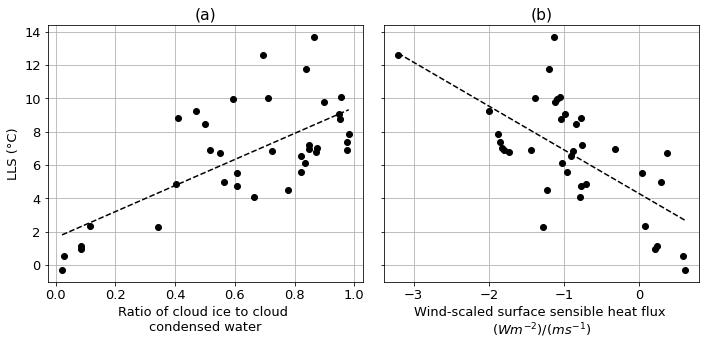

In [28]:
plt.rcParams.update({'font.size': 13})

data = model_means_all_vars.copy()
x_vars = ['clivi_div_clwvi', 'windscaled_hfss']
y_vars = ['LLS', 'LLS']
x_labs = ['Ratio of cloud ice to cloud \ncondensed water',
          'Wind-scaled surface sensible heat flux \n($Wm^{-2}$)/($ms^{-1}$)']
          
y_labs = ['LLS (°C)', 'LLS (°C)']
titles=['(a)', '(b)']
pal = ['gray', 'blue', 'red']

fig, axs = plt.subplots(1,2,figsize=(10,5), sharey=True)
xpos = [0.1, 0.62]
for i in [0, 1]:
    ax=axs[i] 
    ax.scatter(data[x_vars[i]], data[y_vars[i]], c='black')
    ax.set_xlabel(x_labs[i])
    
    
    regression = stats.linregress(x=data[x_vars[i]].astype(float),
                              y=data[y_vars[i]].astype(float))
    r= regression.rvalue
    p = regression.pvalue
    print(p)
    r2 = (regression.rvalue)**2
    xs= np.linspace(np.min(data[x_vars[i]]), np.max(data[x_vars[i]]), 1000)
    ys = (regression.slope*xs)+regression.intercept
    ax.plot(xs, ys, c='black', ls='--')
    print('R\u00b2: '+str(np.round(r2,2)))
    #ax.text(xpos[i], 0.95, 'R\u00b2: '+str(np.round(r2,2)), 
    #        transform=ax.transAxes, fontsize='medium')
    #ax.axvline(0, c='gray', alpha=1, lw=1, ls='--')
    #ax.axhline(0, c='gray', alpha=1, lw=1, ls='--')
    ax.grid()
    ax.set_title(titles[i])
    axs[0].set_ylabel(y_labs[0])
    
axs[0].set_ylabel(y_labs[0])
axs[0].set_axisbelow(True)
axs[1].set_axisbelow(True)
plt.tight_layout()
plt.savefig('Figures/clwvi_clivi_and_hfss_scatters.jpg', dpi=450, bbox_inches='tight')

In [26]:
final_plot_mods = model_means_all_vars.Model.unique()
missing_mods = [x for x in models if not x in final_plot_mods]
missing_mods

# models below are those for which data is unavailable...
# ... for one of the variables in the figure above, so are excluded

['CAS-ESM2-0',
 'CIESM',
 'E3SM-1-0',
 'GISS-E2-1-H',
 'GISS-E2-2-H',
 'NESM3',
 'NorCPM1',
 'UKESM1-1-LL']